# Facies discrimination using elemental intensities
Here we try the rolling trick to gather neighboring information into one scanning point.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Data representation
1. Pair labels to data
1. Centred log-ratio transform (normalization)
1. rolling

## Pair labels to data
The label is latest produced by build_labels.ipynb. It is in a simple manner.

In [35]:
info_df = pd.read_csv('data/info.cleaned.all.csv', usecols=['composite_id', 'composite_depth_mm', 'section_depth_mm', 'core_id', 'core_section'], index_col=0)
print(info_df.head())
print(info_df.shape)

              composite_depth_mm core_id core_section  section_depth_mm
composite_id                                                           
N10_00001                      1     N10        N10-5               1.0
N10_00003                      3     N10        N10-5               3.0
N10_00005                      5     N10        N10-5               5.0
N10_00007                      7     N10        N10-5               7.0
N10_00009                      9     N10        N10-5               9.0
(170436, 4)


In [4]:
data_df = pd.read_csv('data/XRF_results.cleaned.all.csv', usecols=['composite_id', 'Ba', 'Br', 'Ca', 'Cl', 'Fe', 'K', 'Rb', 'S', 'Si', 'Sr', 'Ti', 'Zr'], index_col=0)
print(data_df.head())
print(data_df.shape)

               Ba  Br     Ca   Cl    Fe     K   Rb   S    Si   Sr    Ti    Zr
composite_id                                                                 
N10_00001     130   8   6267  574  1859  2409   42  25  4647  227  1528  1270
N10_00003     149   0   6327  674  2384  2693  124  57  5522  158  1408  1549
N10_00005     125   8   7200  643  2171  2795  170  40  5153  205  1025  1369
N10_00007     102  11   5992  596  1879  2673  131   7  5208  207  1225  1199
N10_00009     127   0  10409  598  2095  2751   98  13  5045  226  1758   968
(170436, 12)


In [39]:
spe_df = pd.read_csv('data/XRF_spe.cleaned.all.csv', index_col=0)
print(spe_df.head())
print(spe_df.shape)

              1  2  3  4  5  6  7  8  9  10  ...  1015  1016  1017  1018  \
composite_id                                 ...                           
N10_00001     0  0  0  0  0  0  0  0  0   0  ...    82    77    83    84   
N10_00003     0  0  0  0  0  0  0  0  0   0  ...    86    87    92    77   
N10_00005     0  0  0  0  0  0  0  0  0   0  ...    95    77    84    68   
N10_00007     0  0  0  0  0  0  0  0  0   0  ...    84    81    98    84   
N10_00009     0  0  0  0  0  0  0  0  0   0  ...    76    79    80    76   

              1019  1020  1021  1022  1023  1024  
composite_id                                      
N10_00001      100    81    77    90    74     2  
N10_00003       87   102    97    83    85    10  
N10_00005       96    80    72    73    92    23  
N10_00007       82    81    99    80   100    26  
N10_00009       95    81    82    76    85    12  

[5 rows x 1024 columns]
(170436, 1024)


In [13]:
y = pd.read_csv('data/XRF_y_label.csv', index_col=0, squeeze=True)
y.shape

(158909,)

In [36]:
ml_df = pd.concat([info_df, y, data_df], axis=1, join='inner')
ml_df

,composite_depth_mm,core_id,core_section,section_depth_mm,facies_merge_1,Ba,Br,Ca,Cl,Fe,K,Rb,S,Si,Sr,Ti,Zr
composite_id,,,,,,,,,,,,,,,,,
N10_00003,3,N10,N10-5,3.0,0,149,0,6327,674,2384,2693,124,57,5522,158,1408,1549
N10_00005,5,N10,N10-5,5.0,0,125,8,7200,643,2171,2795,170,40,5153,205,1025,1369
N10_00007,7,N10,N10-5,7.0,0,102,11,5992,596,1879,2673,131,7,5208,207,1225,1199
N10_00009,9,N10,N10-5,9.0,0,127,0,10409,598,2095,2751,98,13,5045,226,1758,968
N10_00011,11,N10,N10-5,11.0,0,144,30,13011,560,1997,2699,80,25,5082,252,1756,1334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02163,2163,W5,W5-1,2163.0,6,72,380,5193,4204,717,430,43,894,8,202,0,33
W5_02183,2183,W5,W5-1,2183.0,6,98,330,4630,4111,231,526,0,866,18,211,0,33
W5_02185,2185,W5,W5-1,2185.0,6,77,463,4266,4166,437,439,0,792,11,218,16,75


In [37]:
np.unique(ml_df.facies_merge_1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [40]:
ml_spe_df = pd.concat([info_df, y, spe_df], axis=1, join='inner')
ml_spe_df

,composite_depth_mm,core_id,core_section,section_depth_mm,facies_merge_1,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_00003,3,N10,N10-5,3.0,0,0,0,0,0,0,...,86,87,92,77,87,102,97,83,85,10
N10_00005,5,N10,N10-5,5.0,0,0,0,0,0,0,...,95,77,84,68,96,80,72,73,92,23
N10_00007,7,N10,N10-5,7.0,0,0,0,0,0,0,...,84,81,98,84,82,81,99,80,100,26
N10_00009,9,N10,N10-5,9.0,0,0,0,0,0,0,...,76,79,80,76,95,81,82,76,85,12
N10_00011,11,N10,N10-5,11.0,0,0,0,0,0,0,...,83,88,83,76,74,92,80,87,88,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02163,2163,W5,W5-1,2163.0,6,0,0,0,0,0,...,101,99,100,85,103,98,109,84,93,10
W5_02183,2183,W5,W5-1,2183.0,6,0,0,0,0,0,...,105,93,104,94,94,76,96,109,97,0
W5_02185,2185,W5,W5-1,2185.0,6,0,0,0,0,0,...,107,114,90,86,90,99,88,102,82,21


In [41]:
#ml_df.to_csv('data/XRF_ML.csv')
ml_spe_df.to_csv('data/XRF_spe_ML.csv')

## Normalization sample-wides
clr

In [19]:
from scipy.stats.mstats import gmean

x = data_df.values
# replace the zero to 1
x = np.where(x == 0, 1, x) 
x = np.log(x / gmean(x, axis = 1).reshape(x.shape[0], 1))

print(x.shape)

(170436, 12)


In [20]:
x[:4]

array([[-1.18758048, -3.97567339,  2.68793812,  0.29751447,  1.47267906,
         1.73185207, -2.31744531, -2.83623911,  2.3888622 , -0.63016491,
         1.27660004,  1.09165725],
       [-1.08625516, -6.09020147,  2.66238   ,  0.42302864,  1.68633356,
         1.80820962, -1.2699199 , -2.0471502 ,  2.52629392, -1.02760644,
         1.15972407,  1.25516337],
       [-1.39865066, -4.14752286,  2.65487191,  0.23918032,  1.45597877,
         1.70862299, -1.09116596, -2.53808495,  2.32036995, -0.90395442,
         0.70548349,  0.99487143],
       [-1.412732  , -3.63980954,  2.66047572,  0.35253586,  1.50079019,
         1.85325191, -1.16250749, -4.09179466,  2.52024637, -0.70498602,
         1.07299131,  1.05153834]])

# Rolling
The trick is to use the mean and standard deviation of the neighboring points to represent the data points. It does more than moving-window smoothing because the standard deviation is also counted. The step-size resolution of XRF is 2 mm, and the thickness of bedding is predominantly between 0.3 and 30 mm, so I set the total length of moving window as 17 points. The problem of information leakage from the test set to the training set later has been taken care since the moving window only excecuted with each section, and the spliting process will take section as a unit instead of data point. This actually indicates the lose of those edge data at the top and bottom of section.

This time the order with section is sorted by the section depth and there shouldn't have gaps produced by the previous filtering step to cause problem.

In [42]:
new_cols = []
for fun in ['_mean', '_std']:
    new_cols = np.hstack((new_cols, [col+fun for col in data_df.columns]))
new_cols

array(['Ba_mean', 'Br_mean', 'Ca_mean', 'Cl_mean', 'Fe_mean', 'K_mean',
       'Rb_mean', 'S_mean', 'Si_mean', 'Sr_mean', 'Ti_mean', 'Zr_mean',
       'Ba_std', 'Br_std', 'Ca_std', 'Cl_std', 'Fe_std', 'K_std',
       'Rb_std', 'S_std', 'Si_std', 'Sr_std', 'Ti_std', 'Zr_std'],
      dtype='<U32')

In [43]:
norm_df = pd.concat(
    [pd.DataFrame(x, index = data_df.index, columns = cols), ml_df[['core_section', 'facies_merge_1']]],
    join = 'inner', axis = 1
)
norm_df.columns

Index(['Ba', 'Br', 'Ca', 'Cl', 'Fe', 'K', 'Rb', 'S', 'Si', 'Sr', 'Ti', 'Zr',
       'core_section', 'facies_merge_1'],
      dtype='object')

In [44]:
norm_df.head()

,Ba,Br,Ca,Cl,Fe,K,Rb,S,Si,Sr,Ti,Zr,core_section,facies_merge_1
composite_id,,,,,,,,,,,,,,
N10_00003,-1.086255,-6.090201,2.662380,0.423029,1.686334,1.808210,-1.269920,-2.047150,2.526294,-1.027606,1.159724,1.255163,N10-5,0
N10_00005,-1.398651,-4.147523,2.654872,0.239180,1.455979,1.708623,-1.091166,-2.538085,2.320370,-0.903954,0.705483,0.994871,N10-5,0
N10_00007,-1.412732,-3.639810,2.660476,0.352536,1.500790,1.853252,-1.162507,-4.091795,2.520246,-0.704986,1.072991,1.051538,N10-5,0
N10_00009,-1.114063,-5.958250,3.292176,0.435341,1.689059,1.961470,-1.373283,-3.393301,2.567903,-0.537715,1.513682,0.916982,N10-5,0
N10_00011,-1.363775,-2.932391,3.139962,-0.005651,1.265813,1.567048,-1.951562,-3.114712,2.199872,-0.804159,1.137206,0.862349,N10-5,0


In [45]:
# make sure the order is sorted by the composite_id and then the order within section is sorted by the section depth simultaneously.
norm_df = norm_df.sort_values('composite_id')
norm_df.shape

(158909, 14)

In [46]:
r_df = pd.DataFrame()
cols = norm_df.columns[:-2]
for section in np.unique(norm_df.core_section):
    rolling = norm_df.loc[norm_df.core_section == section, cols].rolling(window = 17, center = True)
    r_df = r_df.append(pd.concat([rolling.mean(), rolling.std()], axis = 1, join = 'inner'))

r_df.columns = new_cols
r_df = pd.concat([r_df, norm_df.loc[:, ['facies_merge_1', 'core_section']]], join = 'inner', axis = 1)

print(norm_df.shape)
print(r_df.shape)

(158909, 14)
(158909, 26)


In [47]:
r_df.head(10)

,Ba_mean,Br_mean,Ca_mean,Cl_mean,Fe_mean,K_mean,Rb_mean,S_mean,Si_mean,Sr_mean,...,Fe_std,K_std,Rb_std,S_std,Si_std,Sr_std,Ti_std,Zr_std,facies_merge_1,core_section
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_03444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,N10-1
N10_03460,-2.149582,-2.301706,3.358506,0.730416,2.535087,1.698956,-1.611358,-1.703103,0.070642,-0.968070,...,0.059833,0.046311,0.138985,0.136754,0.091019,0.060907,0.053279,0.144020,1,N10-1


In [54]:
r_c_df = r_df.dropna(axis = 0).copy()
print(r_df.shape)
print(r_c_df.shape)

(158909, 26)
(153357, 26)


## Check data

In [49]:
len(np.unique(r_c_df.core_section))

347

In [50]:
na_df = norm_df.loc[r_df[r_df.iloc[:, 1].isna()].index]
unique, count = np.unique(na_df.core_section, return_counts=True)
print(count)

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16

In [51]:
print(np.unique(count))
print(len(r_c_df)/len(r_df)*100)

[16]
96.50617649094765


All sections have 16 nans due to the rolling.

## Export the represented data

In [52]:
r_c_df.to_csv('data/XRF_ML_cr.csv')

# Plot the conjunction matrix
Let's see how the facies changes before we go ML.

In [55]:
#r_c_df = pd.read_csv('database/XRF_ML_cr.csv', index_col = 0)
r_c_df['id'] = range(len(r_c_df))  # re-build the manual idex

In [56]:
y_mean = []
composite_id = []
for section in np.unique(r_c_df.core_section):
    y_mean = np.hstack((y_mean, r_c_df.facies_merge_1[r_c_df.core_section == section].rolling(window = 2).mean()))
    composite_id = np.hstack((composite_id, r_c_df.index[r_c_df.core_section == section]))

# merge the rolling with the original label
# this will lost the first data poit in each section, but it doesn't mater
# because the boundary shouldn't be at the begining of each section
y_df = pd.concat([r_c_df.facies_merge_1, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna(), r_c_df.id], join = 'inner', axis = 1)

In [58]:
bd_df = y_df[y_df.facies_merge_1 != y_df.y_mean].copy()
bd_df['ab_id'] = bd_df.id - 1
bd_df

,facies_merge_1,y_mean,id,ab_id
N10_02925,1,0.5,775,774
N11_02875,4,2.5,2138,2137
N11_03105,5,4.5,2253,2252
N11_03155,6,5.5,2278,2277
N11_03255,7,6.5,2328,2327
...,...,...,...,...
W3_02861,8,7.5,150317,150316
W3_01561,1,2.0,150614,150613
W4_02215,1,2.0,151474,151473
W4_02533,6,3.5,151633,151632


In [59]:
print('There are {} boundaries.'.format(len(bd_df)))

There are 146 boundaries.


In [60]:
np.unique(r_c_df.facies_merge_1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [63]:
bd_mat = np.zeros(shape = (12, 12), dtype = int)

for row in bd_df.iterrows():
    tmp = np.zeros(shape = (12, 12), dtype = int)
    tmp[r_c_df.facies_merge_1[int(row[1].ab_id)], r_c_df.facies_merge_1[int(row[1].id)]] = 1
    bd_mat += tmp

del tmp
print(bd_mat)
print(bd_mat.shape)

[[ 0  7  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  4  3  2  4  0  1  2  4  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  3  4  1  0  0  0  0]
 [ 0  0  0  2  0  2  2  0  0  1  0  0]
 [ 0  0  0  0  1  0 16  1  0  0  0  0]
 [ 0  0  0  0  0  8  0 18  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 14  4  0  1]
 [ 0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  1]
 [ 0  0  0  0  0  0  0  0  0  2  0  7]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]]
(12, 12)


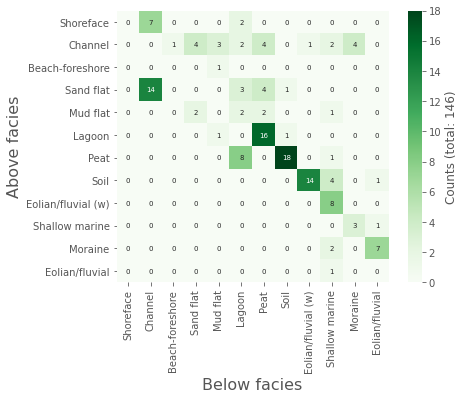

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #center = 50,
            xticklabels = Facies, yticklabels = Facies, fmt = 's', 
            annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
           )
ax.set_xlabel('Below facies', size = 16)
ax.set_ylabel('Above facies', size = 16)
fig.savefig('results/conjunction_matrix_y_{}.png'.format(date))